# LSTM WITH ABSTRACT AND TITLE 

#### FOUNDATION OF DEEP LEARNING

*Master Degree in Data Science* <br>
*University of Milano-Bicocca* <br> <br> 

Filippo Algeri, Marta Brasola, Maurizio Papa


In this notebook analyzed whether including the title could improve the performance of the models. We based the architecture of the LSTM on some other tests we ran before with keras tuner that gave us an indication for type and numer of layers and some parameters.

In [7]:
import warnings
warnings.filterwarnings("ignore", category= UserWarning)


import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import TextVectorization
from tensorflow.keras.layers import Embedding

In [8]:
train = pd.read_csv('/kaggle/input/fdl-arxiv-final/train_resampled.csv')
test = pd.read_csv('/kaggle/input/fdl-arxiv-final/test.csv')

## Code used for tuning

In [ ]:
'''# Define the model-building function
def build_model(hp):
    
    model = keras.Sequential()
    
    # dropout parameter
    dropout_rate = hp.Float('dropout_rate',
                            min_value=0,
                            max_value = 0.5,
                            step=0.1)
    
    # number of units parameter
    n_units = hp.Int("units", min_value=32, max_value=512, step=32)
    
    learning_rates = hp.Choice('learning_rate', [1e-2, 1e-3, 1e-4])
    
        #optimizer = hp.Choice('optimizer', values=[
    #    keras.optimizers.SGD(learning_rate = learning_rates),
     #   keras.optimizers.Adam(learning_rate = learning_rates),
     #   keras.optimizers.RMSprop(learning_rate = learning_rates)])
    
    # embedding layer
    model.add(keras.layers.Embedding(
        total_words + 2,
        embedding_dim,
        embeddings_initializer=keras.initializers.Constant(embedding_matrix),
        trainable=False
    ))
    
    # Option 1: Bidirectional LSTM
    if hp.Choice('first_layer', values=['bidirectional_lstm', 'lstm_with_return_seq']) == 'bidirectional_lstm':
        model.add(keras.layers.Bidirectional(keras.layers.LSTM(n_units, input_shape = (1,200))))
    
    # Option 2: LSTM with return sequences
    else:
        model.add(keras.layers.LSTM(n_units, dropout=0.1, return_sequences=True, input_shape = (1,200)))
        model.add(keras.layers.LSTM(n_units, dropout=0.1, return_sequences=False))
    
    # Condition if I want a Dropout layer
    if hp.Boolean('dropout1'):
        model.add(keras.layers.Dropout(dropout_rate))
        
    model.add(keras.layers.Dense(n_units, activation='relu'))
    
    # Condition if I want a Dropout layer
    if hp.Boolean('dropout2'):
        model.add(keras.layers.Dropout(dropout_rate))        
        
    model.add(keras.layers.Dense(20, activation='softmax'))  # Output layer
    
    model.compile(optimizer=keras.optimizers.RMSprop(learning_rate = learning_rates),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    
    return model

# Configure the tuner
tuner = keras_tuner.RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=15,
    directory="/kaggle/working/",
    project_name="tune_hypermodel")

# Start the hyperparameter search
tuner.search(X_train, y_train, epochs=5, validation_data=(X_test, y_test), batch_size = 128)'''

## Vectorizing and Embedding

In [9]:
# Shuffle the train and test data while maintaining the order
train_shuffled = train.sample(frac=1, random_state=42)
test_shuffled = test.sample(frac=1, random_state=42)

# Split the shuffled data into X (input features) and y (target variable)
X_train = train_shuffled[['abstract', 'title']]
y_train = train_shuffled['labels']

X_test = test_shuffled[['abstract', 'title']]
y_test = test_shuffled['labels']

In [10]:
# Vectorize the text data using TextVectorization
max_words = 100000  # Maximum number of words to keep in the vocabulary
words_per_sentence_abstract = 200  # Maximum number of words per sentence in abstract
words_per_sentence_title = 40  # Maximum number of words per sentence in title
embedding_dim = 100

In [11]:
vectorizer_abstract = keras.layers.TextVectorization(max_tokens=max_words, output_sequence_length=words_per_sentence_abstract)
vectorizer_abstract.adapt(X_train['abstract'].values.tolist())

vectorizer_title = keras.layers.TextVectorization(max_tokens=max_words, output_sequence_length=words_per_sentence_title)
vectorizer_title.adapt(X_train['title'].values.tolist())

abstract_train_vec = vectorizer_abstract(X_train['abstract'].values)
abstract_test_vec = vectorizer_abstract(X_test['abstract'].values)

title_train_vec = vectorizer_title(X_train['title'].values)
title_test_vec = vectorizer_title(X_test['title'].values)

In [12]:
embeddings_index = {}
with open('/kaggle/input/glove6b100dtxt/glove.6B.100d.txt') as f:
  # For each text line
  for line in f:
    # Separate the word-string from the 100-dimensional-vector-string
    word, coeffs = line.split(maxsplit=1)
    # Convert 100-dimensional vector string into a proper floating point vector
    coeffs = np.fromstring(coeffs, "f", sep=" ")
    # Create a new dictionary entry
    embeddings_index[word] = coeffs

print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [13]:
embedding_matrix = np.zeros((max_words+2, embedding_dim))

# For each word in our vocabulary
for i, word in enumerate(vectorizer_abstract.get_vocabulary()):
    # Search corresponding embedding in GloVe,
    # and add it in the correct row of the embedding matrix
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
    # else: words not found in embedding index will be all-zeros.

In [14]:
# plot training history
def plot_history(network_history):
    
    plt.figure(figsize = (13, 6))
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('model loss')
    plt.plot(network_history.history['loss'])
    plt.plot(network_history.history['val_loss'])
    plt.legend(['Training', 'Validation'])

    plt.figure(figsize = (13, 6))
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('model accuracy')
    plt.plot(network_history.history['accuracy'])
    plt.plot(network_history.history['val_accuracy'])
    plt.legend(['Training', 'Validation'], loc='lower right')
    plt.show()

In [15]:
callback = tf.keras.callbacks.EarlyStopping(monitor='acc', patience=2)

# model without dropout

In [18]:
abstract_input = keras.layers.Input(shape=(1,), dtype='string')
abstract_vec = vectorizer_abstract(abstract_input)
abstract_emb = keras.layers.Embedding(max_words + 2,
        embedding_dim,
        embeddings_initializer=keras.initializers.Constant(embedding_matrix),
        trainable=False)(abstract_vec)
abstract_lstm = keras.layers.Bidirectional(keras.layers.LSTM(128))(abstract_emb)
abstract_model = keras.models.Model(inputs=abstract_input, outputs=abstract_lstm)

title_input = keras.layers.Input(shape=(1,), dtype='string')
title_vec = vectorizer_title(title_input)
title_emb = keras.layers.Embedding(input_dim=max_words, output_dim=embedding_dim, input_length=words_per_sentence_title)(title_vec)
title_lstm = keras.layers.Bidirectional(keras.layers.LSTM(128))(title_emb)
title_model = keras.models.Model(inputs=title_input, outputs=title_lstm)

merged = keras.layers.Concatenate()([abstract_model.output, title_model.output])
merged_dense = keras.layers.Dense(units=288, activation='relu', kernel_initializer=keras.initializers.HeNormal(seed=42))(merged)
output = keras.layers.Dense(units=len(set(y_train)), activation='softmax')(merged_dense)

model_without_dropout = keras.models.Model(inputs=[abstract_model.input, title_model.input], outputs=output)
model_without_dropout.compile(optimizer='rmsprop',
              loss='sparse_categorical_crossentropy',
              metrics= 'accuracy')

history = model_without_dropout.fit([X_train['abstract'].values, X_train['title'].values], y_train, epochs=10, batch_size=128,
          validation_data=([X_test['abstract'].values, X_test['title'].values], y_test))

Epoch 1/10
348/348 [==============================] - 46s 102ms/step - loss: 1.1986 - accuracy: 0.5730 - val_loss: 0.8154 - val_accuracy: 0.7556
Epoch 2/10
348/348 [==============================] - 21s 60ms/step - loss: 0.7891 - accuracy: 0.7268 - val_loss: 0.9991 - val_accuracy: 0.6484
Epoch 3/10
348/348 [==============================] - 20s 57ms/step - loss: 0.6342 - accuracy: 0.7822 - val_loss: 0.6562 - val_accuracy: 0.7860
Epoch 4/10
348/348 [==============================] - 19s 55ms/step - loss: 0.5323 - accuracy: 0.8177 - val_loss: 0.5449 - val_accuracy: 0.8279
Epoch 5/10
348/348 [==============================] - 19s 54ms/step - loss: 0.4513 - accuracy: 0.8489 - val_loss: 0.6982 - val_accuracy: 0.7680
Epoch 6/10
348/348 [==============================] - 17s 50ms/step - loss: 0.3769 - accuracy: 0.8740 - val_loss: 0.9974 - val_accuracy: 0.7051
Epoch 7/10
348/348 [==============================] - 18s 51ms/step - loss: 0.3092 - accuracy: 0.8976 - val_loss: 0.6784 - val_accuracy

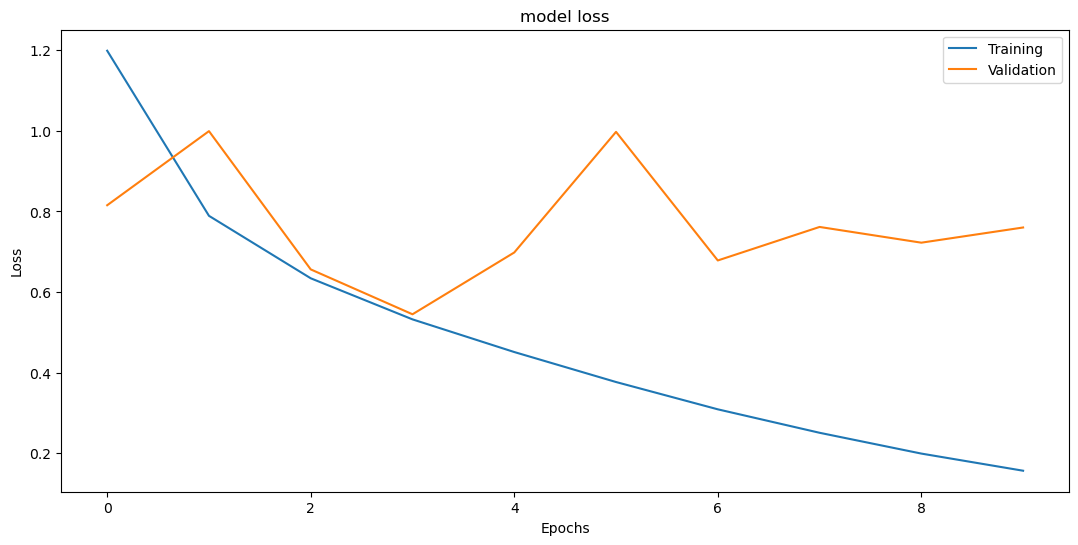

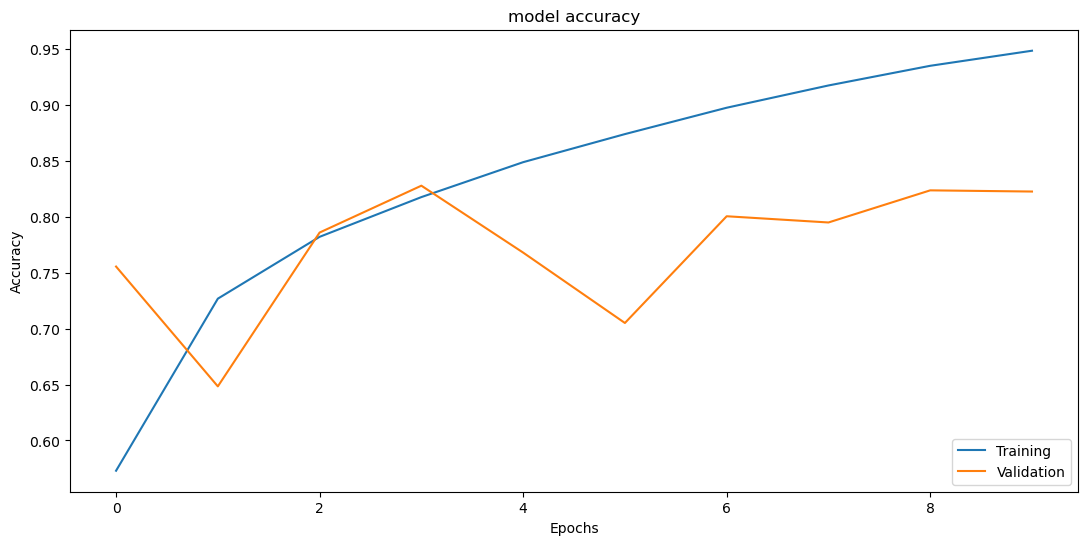

In [20]:
plot_history(history)

## Model with dropout and class weights for the loss

In [21]:
class_frequencies = np.bincount(y_test)
total_samples = np.sum(class_frequencies)
class_weights = total_samples / (len(class_frequencies) * class_frequencies)
class_weights

array([ 0.22475977,  0.62204007, 11.05177994,  0.65748941, 28.94067797,
        6.56730769,  8.01643192, 49.49275362])

In [22]:
abstract_input = keras.layers.Input(shape=(1,), dtype='string')
abstract_vec = vectorizer_abstract(abstract_input)
abstract_emb = keras.layers.Embedding(max_words + 2,
        embedding_dim,
        embeddings_initializer=keras.initializers.Constant(embedding_matrix),
        trainable=False)(abstract_vec)
abstract_lstm = keras.layers.Bidirectional(keras.layers.LSTM(128, dropout=0.1))(abstract_emb)
abstract_model = keras.models.Model(inputs=abstract_input, outputs=abstract_lstm)

title_input = keras.layers.Input(shape=(1,), dtype='string')
title_vec = vectorizer_title(title_input)
title_emb = keras.layers.Embedding(input_dim=max_words, output_dim=embedding_dim, input_length=words_per_sentence_title)(title_vec)
title_lstm = keras.layers.Bidirectional(keras.layers.LSTM(128, dropout=0.1))(title_emb)
title_model = keras.models.Model(inputs=title_input, outputs=title_lstm)

merged = keras.layers.Concatenate()([abstract_model.output, title_model.output])
merged_dense = keras.layers.Dense(units=288, activation='relu')(merged)
merged_dense = keras.layers.Dropout(0.2)(merged)
output = keras.layers.Dense(units=len(set(y_train)), activation='softmax')(merged_dense)

model_better = keras.models.Model(inputs=[abstract_model.input, title_model.input], outputs=output)
model_better.compile(optimizer='rmsprop',
              loss='sparse_categorical_crossentropy',
              metrics= 'accuracy',
              loss_weights = class_weights)


history1 = model_better.fit([X_train['abstract'].values, X_train['title'].values], y_train, epochs=10, batch_size=128,
          validation_data=([X_test['abstract'].values, X_test['title'].values], y_test))

Epoch 1/10
348/348 [==============================] - 36s 84ms/step - loss: 15.1688 - accuracy: 0.5887 - val_loss: 10.7270 - val_accuracy: 0.7406
Epoch 2/10
348/348 [==============================] - 20s 58ms/step - loss: 9.7016 - accuracy: 0.7458 - val_loss: 8.7602 - val_accuracy: 0.7986
Epoch 3/10
348/348 [==============================] - 20s 56ms/step - loss: 8.0189 - accuracy: 0.7951 - val_loss: 8.4807 - val_accuracy: 0.7944
Epoch 4/10
348/348 [==============================] - 19s 53ms/step - loss: 6.9113 - accuracy: 0.8241 - val_loss: 9.0642 - val_accuracy: 0.7748
Epoch 5/10
348/348 [==============================] - 19s 55ms/step - loss: 6.0279 - accuracy: 0.8482 - val_loss: 7.2086 - val_accuracy: 0.8277
Epoch 6/10
348/348 [==============================] - 19s 55ms/step - loss: 5.3169 - accuracy: 0.8650 - val_loss: 8.0255 - val_accuracy: 0.8154
Epoch 7/10
348/348 [==============================] - 19s 55ms/step - loss: 4.6871 - accuracy: 0.8820 - val_loss: 9.1780 - val_accurac

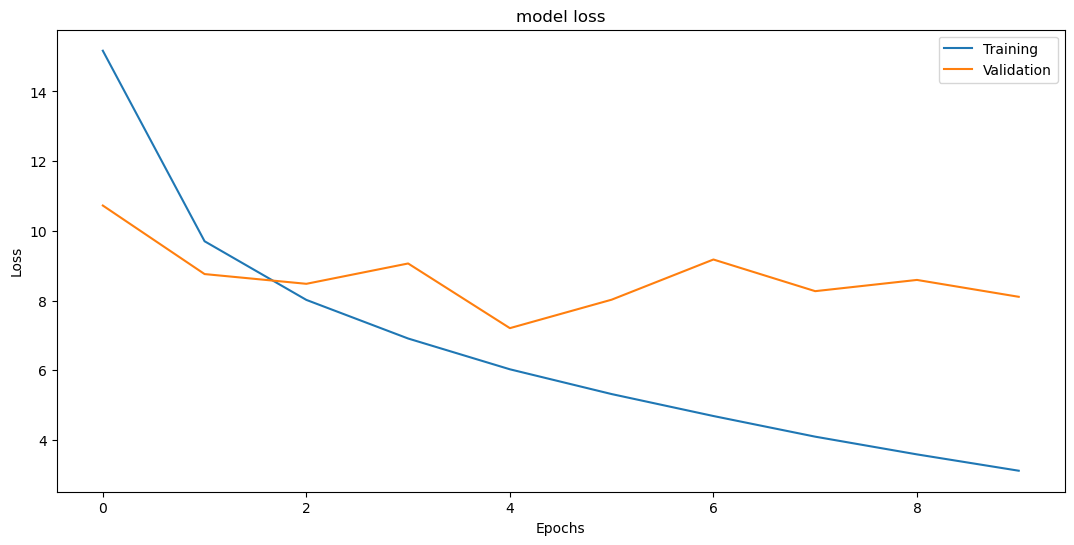

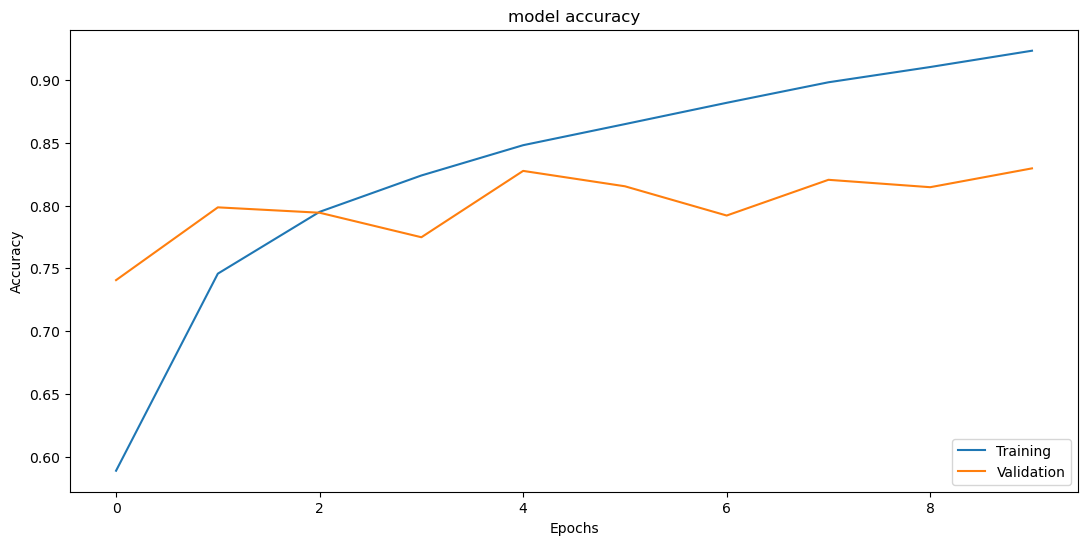

In [23]:
plot_history(history1)

In [26]:
model_better.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 input_4 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 text_vectorization_2 (TextVect  (None, 200)         0           ['input_3[0][0]']                
 orization)                                                                                       
                                                                                                  
 text_vectorization_3 (TextVect  (None, 40)          0           ['input_4[0][0]']          